# Deploy and Evaluate Mistral NeMo Instruct Capabilities

## Mistral Nemo Instruct 2407 Model

In this notebook, you learn how you can deploy Mistral NeMo Instruct model from Bedrock Marketplace and use the model using Converse APIs.
Mistral NeMo is a state-of-the-art 12B model with **128k context length**, built in collaboration with NVIDIA, and released under the Apache 2.0 license. The Mistral-Nemo-Instruct-2407 Large Language Model (LLM) is an instruct fine-tuned version of the Mistral-Nemo-Base-2407. NeMo is trained jointly by Mistral AI and NVIDIA, it significantly outperforms existing models smaller or similar in size.

**Key features**

Mistral NeMo features a 128k token context window, enabling processing of extensive long-form content. The model demonstrates strong performance in reasoning, world knowledge, and coding accuracy. Both pre-trained base and instruction-tuned checkpoints are available under the Apache 2.0 license, making it accessible for researchers and enterprises. The model’s quantization-aware training facilitates optimal FP8 inference performance without compromising quality.

- Released under the Apache 2 License
- Pre-trained and instructed versions
- Trained with a 128k context window
- Trained on a large proportion of multilingual and code data
- Drop-in replacement of Mistral 7B


Mistral Nemo is a transformer model, with the following architecture choices:
- Layers: 40
- Dim: 5,120
- Head dim: 128
- Hidden dim: 14,336
- Activation Function: SwiGLU
- Number of heads: 32
- Number of kv-heads: 8 (GQA)
- Vocabulary size: 2**17 ~= 128k
- Rotary embeddings (theta = 1M)

**Input**
- Input Type: Text
- Input Format: String
- Input Parameters: max_tokens, temperature, top_p, stop, frequency_penalty, presence_penalty, seed

**Output**
- Output Type: Text
- Output Format: String

**Software Integration**
- Supported Hardware Platform(s): NVIDIA Hopper
- Preferred Operating System(s): Linux


### Benchmarks
The following table compares the accuracy of the Mistral NeMo base model with two popular open-source pre-trained models, Gemma 2 9B, and Llama 3 8B.

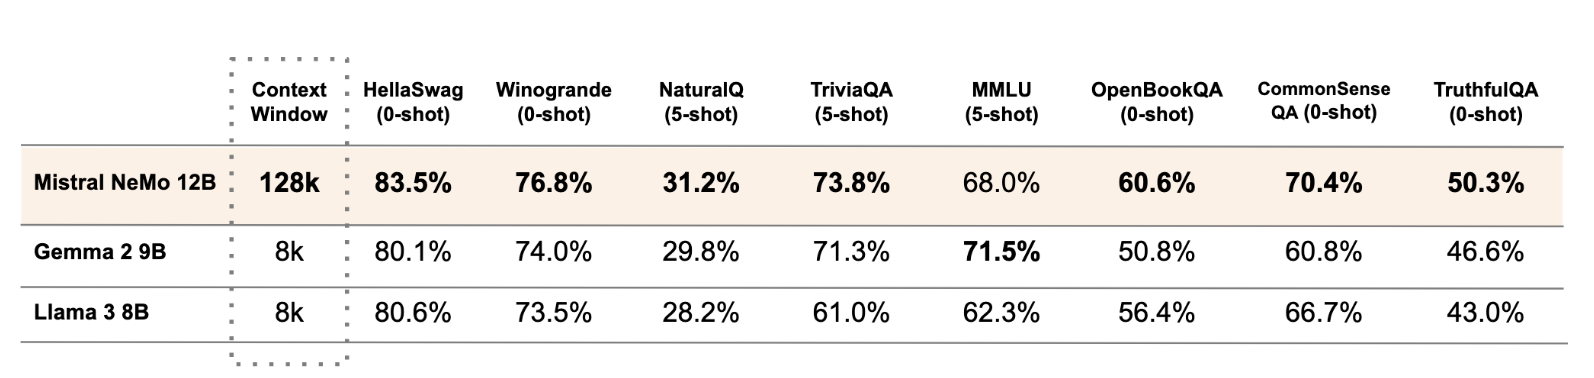


### Multilingual Capabilities
The model is designed for global, multilingual applications. It is trained on function calling, has a large context window, and is particularly strong in **English, French, German, Spanish, Italian, Portuguese, Chinese, Japanese, Korean, Arabic, and Hindi**. This is a new step toward bringing frontier AI models to everyone’s hands in all languages that form human culture.

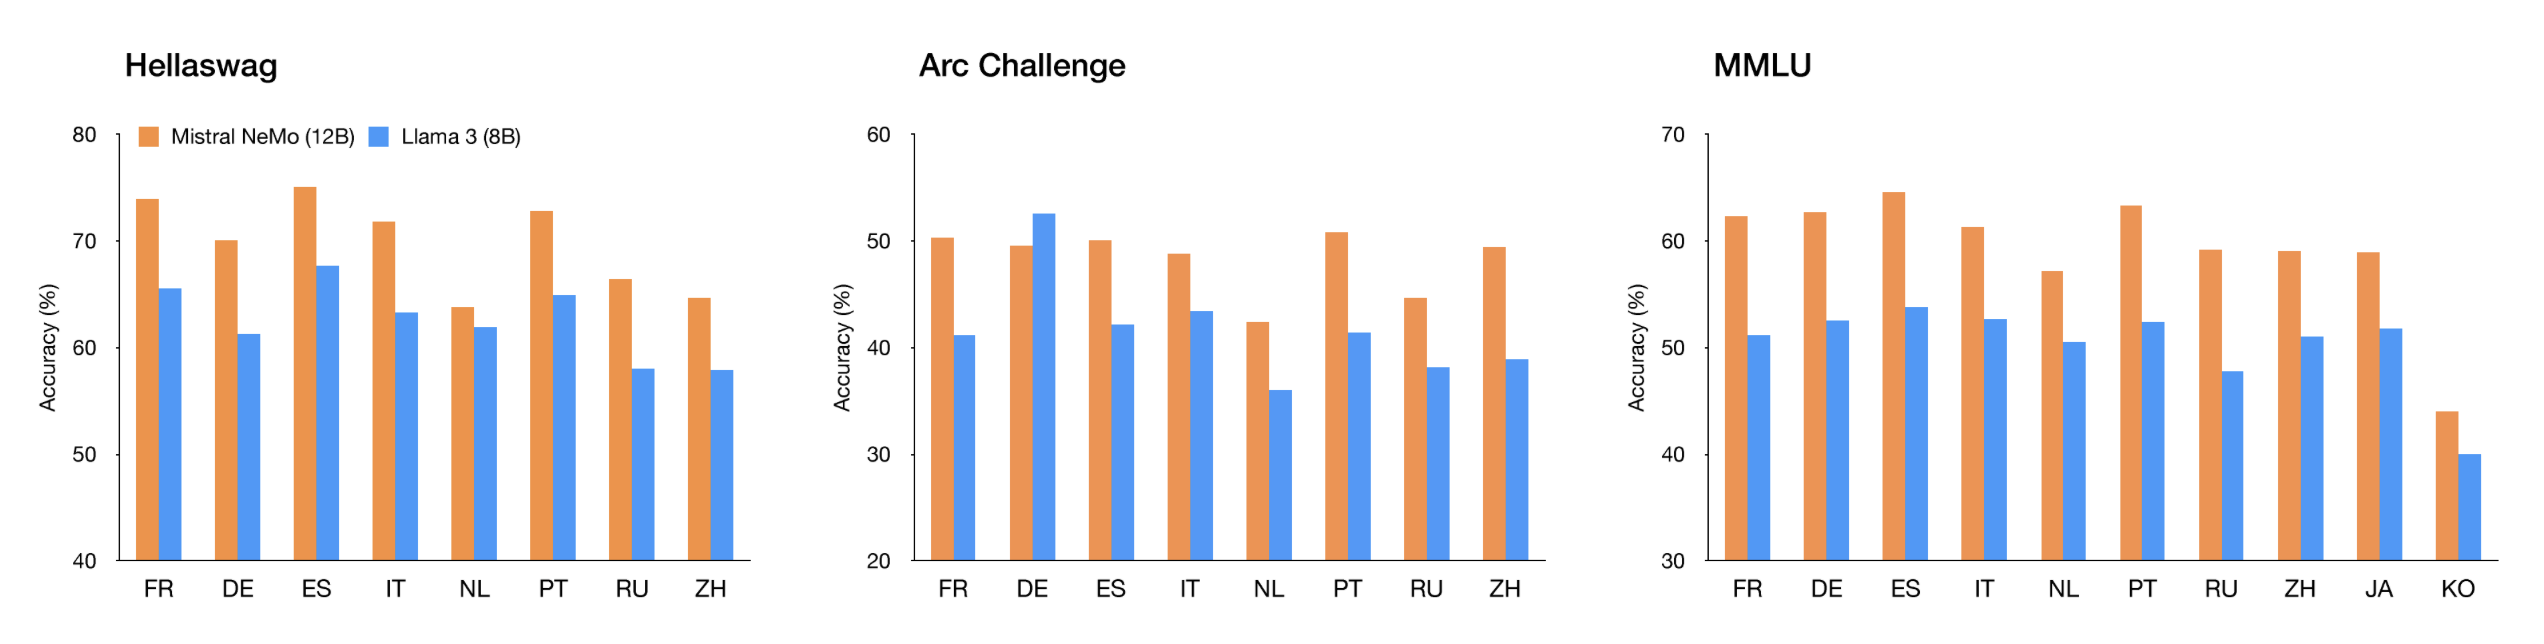

References:  
[Mistral AI Blog](https://mistral.ai/news/mistral-nemo/)  
[NVIDIA Model Card](https://build.nvidia.com/nv-mistralai/mistral-nemo-12b-instruct/modelcard)  
[AWS Blog](https://aws.amazon.com/blogs/machine-learning/mistral-nemo-instruct-2407-and-mistral-nemo-base-2407-are-now-available-on-sagemaker-jumpstart/)

## Setup Dependencies

This notebook uses boto3 and sagemaker modules. Make sure latest versions are installed


In [1]:
%pip install --upgrade pip
%pip install botocore boto3 sagemaker --upgrade --quiet


Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Import the necessary libraries for grabbing sagemaker execution role, bedrock and bedrock runtime API operations


In [2]:
import boto3
import json
import sagemaker
import time
from botocore.exceptions import ClientError

/opt/conda/lib/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Deploy Model from Marketplace

Set default configurations. Copy model source arn from Bedrock Marketplace catalog.

In [3]:
# Set configuration
MODEL_SOURCE_ID = 'huggingface-llm-mistral-nemo-instruct-2407'
MODEL_SOURCE_ARN = 'arn:aws:sagemaker:us-west-2:aws:hub-content/SageMakerPublicHub/Model/huggingface-llm-mistral-nemo-instruct-2407/1.0.3'
INSTANCE_TYPE = 'ml.g6.12xlarge'
ENDPOINT_NAME = 'nemo-on-bedrock'

Grab session role, region and aws account number.

IMPORTANT:
IAM Role must have permissions to create SageMaker endpoint and use marketplace models. Detailed guidance on policy is documented in [Bedrock User Guide](https://docs.aws.amazon.com/bedrock/latest/userguide/setup-amazon-bedrock-marketplace.html).


In [4]:
# function to grab aws account id, sagemaker execution role and region
def get_current_session_info():
    sagemaker_role_arn = sagemaker.get_execution_role()
    session = sagemaker.Session()
    account_id = session.account_id()
    region = session._region_name

    return account_id, region, sagemaker_role_arn

aws_account_id, aws_region, sagemaker_role_arn = get_current_session_info()
print(f'aws account id: {aws_account_id}')
print(f'aws region: {aws_region}')
print(f'sagemaker role arn: {sagemaker_role_arn}')

aws account id: 074598462996
aws region: us-west-2
sagemaker role arn: arn:aws:iam::074598462996:role/service-role/AmazonSageMaker-ExecutionRole-20231217T114947


In [5]:
# Create bedrock client object
bedrock_client = boto3.client('bedrock')

In [6]:
# create bedrock marketplace endpoint
def create_endpoint(model_source_arn: str, 
                    endpoint_name: str,
                    instance_type: str, 
                    instance_count: int = 1):

    response = bedrock_client.create_marketplace_model_endpoint(
            modelSourceIdentifier=model_source_arn,
            endpointConfig={
                'sageMaker': {
                    'initialInstanceCount': instance_count,
                    'instanceType': instance_type,
                    'executionRole': sagemaker_role_arn,
                }
            },
            acceptEula=True,
            endpointName=endpoint_name
        )
    return response

create_response = create_endpoint(model_source_arn=MODEL_SOURCE_ARN, endpoint_name=ENDPOINT_NAME, instance_type=INSTANCE_TYPE)


In [7]:
# Retrieve endpoint arn from response text

endpoint_arn = create_response['marketplaceModelEndpoint']['endpointArn']
print(endpoint_arn)

arn:aws:sagemaker:us-west-2:074598462996:endpoint/nemo-on-bedrock


In [8]:
#endpoint_arn = 'arn:aws:sagemaker:us-west-2:074598462996:endpoint/nemo-on-bedrock'

In [9]:
# Check endpoint creation status until it's in service

while(True):
    endpoint_reponse = bedrock_client.get_marketplace_model_endpoint(endpointArn=endpoint_arn)
    status = endpoint_reponse['marketplaceModelEndpoint']['endpointStatus']
    print(f'endpoint status: {status}')
    if (status != 'Creating'):
        break

    # wait for 10 seconds
    time.sleep(10)

endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: InService


## Usage Examples

In [10]:
# Create bedrock runtime object

bedrock_runtime = boto3.client("bedrock-runtime")

In [11]:

# Helper function to invoke model using Converse API (without streaming)
def invoke_model(system_prompt: str, messages: list, display_usage=False):
    system = [ { "text": system_prompt } ]
    
    inf_params = {"max_tokens": 2000, "temperature": 1.0}
    
    response = bedrock_runtime.converse(modelId=endpoint_arn, 
                                        messages=messages,
                                        system=system,
                                        additionalModelRequestFields=inf_params)

    # Print Response
    output_message = response['output']['message']
    output_content = ''
    for content in output_message['content']:
        output_content = output_content.join(content['text'])

    if (display_usage):
        token_usage = response['usage']
        print("\t--- Token Usage ---")
        print(f"\tInput tokens:  {token_usage['inputTokens']}")
        print(f"\tOutput tokens:  {token_usage['outputTokens']}")
        print(f"\tTotal tokens:  {token_usage['totalTokens']}")
        
        print(f"\tLatency: {response['metrics']['latencyMs']}")

    
    return output_content

In [12]:
# Helper function to invoke model using Converse API with streaming
def invoke_model_with_stream(system_prompt: str, messages: list):
    system = [ { "text": system_prompt } ]
    
    inf_params = {"max_tokens": 2000, "temperature": 0.4}
    
    response = bedrock_runtime.converse_stream(modelId=endpoint_arn, 
                                        messages=messages,
                                        system=system,
                                        additionalModelRequestFields=inf_params)
    stream = response.get('stream')
    output_content = ''
    if stream:
        for event in stream:

            if 'messageStart' in event:
                print(f"\nRole: {event['messageStart']['role']}")

            if 'contentBlockDelta' in event:
                print(event['contentBlockDelta']['delta']['text'], end="")
                output_content = output_content.join(event['contentBlockDelta']['delta']['text'])

            if 'messageStop' in event:
                print(f"\nStop reason: {event['messageStop']['stopReason']}")

            if 'metadata' in event:
                print(event)
                metadata = event['metadata']
                if 'usage' in metadata:
                    print("\nToken usage")
                    print(f"Input tokens: {metadata['usage']['inputTokens']}")
                    print(
                        f":Output tokens: {metadata['usage']['outputTokens']}")
                    print(f":Total tokens: {metadata['usage']['totalTokens']}")
                if 'metrics' in event['metadata']:
                    print(
                        f"Latency: {metadata['metrics']['latencyMs']} milliseconds")

    return output_content


### Text Generation

Ask question on history

In [13]:
messages = [
    {
        "role": "user",
        "content": [{"text": 'What is the history behind the Napoleonic Wars?'}]
    }
]

output = invoke_model('You are a renowned historian.', messages)
print(f'Response: \n{output}')

Response: 
The Napoleonic Wars (1803-1815) were a series of conflicts involving Napoleonic France and shifting coalitions of European powers, primarily régions of Austria, Russia, Prussia, Great Britain, and Sweden, along with allies from various other parts of Europe and the world. Here's a concise overview of the history behind these wars:

1. **Early career of Napoleon Bonaparte (1769-1799)**: Born in Corsica to a family of minor Italian nobility, Napoleon rose through the ranks of the French Revolutionary Army, demonstrating extraordinary military talent. He played a significant role in the French Revolution, serving as a general and helping to overthrow the French monarchy in 1799.

2. **Intervention in Egypt (1798-1799)**: Napoleon's first move towards empire came when he commanding an invasive force to Egypt in 1798. Although this campaign ended in disaster, Napoleon successfully returned to France and consolidated power, establishing the French Consulate with himself as First C

### Text Summarization

In [14]:
prompt = '''
In recent years, machine learning (ML) has moved from research and development to the mainstream, driven by the increasing number of data sources and scalable cloud-based compute resources. AWS’ customers currently use AI/ML for a wide variety of applications such as call center operations, personalized recommendations, identifying fraudulent activities, social media content moderation, audio and video content analysis, product design services, and identity verification. Industries using AI/ML include healthcare and life sciences, industrial and manufacturing, financial services, media and entertainment, and telecom.

Machine learning, through its use of algorithms to find patterns in data, can bring considerable power to its customers and thus recommends responsibility in its use. AWS is committed to developing fair and accurate AI and ML services and providing you with the tools and guidance needed to build AI and ML applications responsibly. For more information on this important topic, refer to AWS' Responsible AI.

This whitepaper provides you with a set of proven best practices. You can apply this guidance and architectural principles when designing your ML workloads, and after your workloads have entered production as part of continuous improvement. Although the guidance is cloud- and technology-agnostic, the paper also includes guidance and resources to help you implement these best practices on AWS.

The AWS Well-Architected Framework helps you understand the benefits and risks of decisions you make while building workloads on AWS. By using the Framework, you learn operational and architectural best practices for designing and operating workloads in the cloud. It provides a way to consistently measure your operations and architectures against best practices and identify areas for improvement.

Your ML models depend on the quality of input data to generate accurate results. As data changes with time, monitoring is required to continually detect, correct, and mitigate issues with accuracy and performance. This monitoring step might require you to retrain your model over time using the latest refined data.

While application workloads rely on step-by-step instructions to solve a problem, ML workloads enable algorithms to learn from data through an iterative and continuous cycle. The ML Lens complements and builds upon the Well-Architected Framework to address this difference between these two types of workloads.

This paper is intended for those in a technology role, such as chief technology officers (CTOs), architects, developers, data scientists, and ML engineers. After reading this paper, you will understand the best practices and strategies to use when you design and operate ML workloads on AWS.

'''


messages = [
    {
        "role": "user",
        "content": [{"text": prompt}]
    }
]

output = invoke_model('You are a technical writer. Summarize this technical content.', messages)
print(f'Response: \n{output}')

Response: 
**Summary:**

- **Machine Learning (ML) Transition**: ML has shifted from research to mainstream use due to increased data sources and scalable cloud resources, with AWS customers adopting it in various industries (healthcare, finance, media, etc.) for applications like fraud detection, content moderation, and personal recommendations.

- **AWS Commitment to Responsible ML**: AWS prioritizes fair and accurate AI/ML services and provides tools and guidance to build responsible ML applications.

- **Best Practices for ML Workloads**: This whitepaper offers cloud-agnostic architectural principles and best practices for designing and continuously improving ML workloads, including:
  - Monitoring input data quality and retraining models as needed.
  - Utilizing the AWS Well-Architected Framework for consistent measurement and improvement against best practices.

- **Target Audience**: The paper is intended for technology roles such as CTOs, architects, developers, data scientists

### Text Classification

In [15]:
system_prompt = '''
You are an AI assistant tasked with classifying data based on its sensitivity level. The sensitivity levels and their definitions are:

Sensitive: Data that is to have the most limited access and requires a high degree of integrity. This is typically data that will do the most damage to the organization should it be disclosed.
Confidential: Data that might be less restrictive within the company but might cause damage if disclosed.
Private: Private data is usually compartmental data that might not do the company damage but must be kept private for other reasons. Human resources data is one example of data that can be classified as private.
Proprietary: Proprietary data is data that is disclosed outside the company on a limited basis or contains information that could reduce the company's competitive advantage, such as the technical specifications of a new product.
Public: Public data is the least sensitive data used by the company and would cause the least harm if disclosed. This could be anything from data used for marketing to the number of employees in the company.

For each user inquery provided, classify it into one of the above sensitivity levels. Do not include the word "Category". Do not provide explanations or notes.
'''

In [16]:
messages = [
    {
        "role": "user",
        "content": [{"text": "I'm an HR recruiter. What data classifiction category are resumes gathered based on referral by employees?"}]
    }
]

output = invoke_model(system_prompt, messages)
print(f'Response: \n{output}')

Response: 
Private


In [17]:
messages = [
    {
        "role": "user",
        "content": [{"text": "I require the financial statements for the past three fiscal years."}]
    }
]
output = invoke_model(system_prompt, messages)
print(f'Response: \n{output}')

Response: 
Confidential


In [18]:
messages = [
    {
        "role": "user",
        "content": [{"text": "Company's source code"}]
    }
]
output = invoke_model(system_prompt, messages)
print(f'Response: \n{output}')

Response: 
Proprietary


In [19]:
messages = [
    {
        "role": "user",
        "content": [{"text": "I need access to the personnel files containing employee social security numbers and financial information."}]
    }
]
output = invoke_model(system_prompt, messages)
print(f'Response: \n{output}')

Response: 
Sensitive


In [20]:
messages = [
    {
        "role": "user",
        "content": [{"text": "Quarterly regulatory filings with the exchanges"}]
    }
]
output = invoke_model(system_prompt, messages)
print(f'Response: \n{output}')

Response: 
Public


In [21]:
bedrock_client.deregister_marketplace_model_endpoint(endpointArn=endpoint_arn)
bedrock_client.register_marketplace_model_endpoint(modelSourceIdentifier=MODEL_SOURCE_ARN, endpointIdentifier=endpoint_arn)

{'ResponseMetadata': {'RequestId': '2a8de865-e96f-4c42-a378-bb1c2ddbb0c8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Thu, 26 Dec 2024 06:40:41 GMT',
   'content-type': 'application/json',
   'content-length': '812',
   'connection': 'keep-alive',
   'x-amzn-requestid': '2a8de865-e96f-4c42-a378-bb1c2ddbb0c8'},
  'RetryAttempts': 0},
 'marketplaceModelEndpoint': {'endpointArn': 'arn:aws:sagemaker:us-west-2:074598462996:endpoint/nemo-on-bedrock',
  'modelSourceIdentifier': 'arn:aws:sagemaker:us-west-2:aws:hub-content/SageMakerPublicHub/Model/huggingface-llm-mistral-nemo-instruct-2407/1.0.3',
  'status': 'REGISTERED',
  'statusMessage': '',
  'createdAt': datetime.datetime(2024, 12, 26, 6, 40, 41, 132437, tzinfo=tzlocal()),
  'updatedAt': datetime.datetime(2024, 12, 26, 6, 40, 41, 132437, tzinfo=tzlocal()),
  'endpointConfig': {'sageMaker': {'initialInstanceCount': 1,
    'instanceType': 'ml.g6.12xlarge'}},
  'endpointStatus': 'InService'}}

### Email Draft - Raw to Professional

NeMo can be a good model for drafting professional email content.

In [22]:
system_prompt = '''
hi, this is to inform u that you that u don't qualify for this offer.

rgds,
support team
'''

messages = [
    {
        "role": "user",
        "content": [{"text": "You are a professional customer support agent. Your messages are always polite and helpful. You need to re-draft poorly written emails to professional language and tone."}]
    }
]
output = invoke_model(system_prompt, messages)
print(f'Response: \n{output}')

Response: 
Subject: Notification of Ineligibility for Current Offer

Dear [Customer's Name],

I hope this message finds you well. I am writing to inform you that after reviewing your account and the terms of our current promotional offer, we regret to notify you that you do not meet the eligibility criteria at this time.

We understand the disappointment this news may bring and we assure you that we are here to help if you have any questions regarding the offer or your account status. Our team is committed to ensuring you receive the best possible service, and we encourage you to reach out if there's anything we can assist with.

If you believe there may have been a misunderstanding or would like to discuss further, please do not hesitate to respond to this email, and we will be happy to look into the matter. Our team is available Monday through Friday, 9:00 AM to 5:00 PM, to address your concerns.

Thank you for your time and continued trust in our services. We look forward to the opp

### Sentiment Analysis

Below examples demonstrate sentiment analysis capabilities of the model.

In [23]:
system_prompt = '''
Analyze the sentiments of given news headlines, determine if it is positive, neutral, or negative, and return the answer as the corresponding sentiment label "positive" or "neutral" or "negative"
'''

In [24]:
messages = [
    {
        "role": "user",
        "content": [{"text": "a January 11 , 2010 EPHC board of directors has approved an increase in the quarterly dividend from $ 0.03 to $ 0.05 per share"}]
    }
]
output = invoke_model(system_prompt, messages)
print(f'Response: \n{output}')

Response: 
To analyze the sentiment of the given news headline, we'll focus on the keywords and phrases that convey a positive sentiment: "approved," "increase," and "dividend." Based on these, we can determine that the headline expresses a positive sentiment.

Sentiment label: "positive"


In [25]:
messages = [
    {
        "role": "user",
        "content": [{"text": "The company decided at the end of 2008 to temporarily shut down its ammonia plant in Billingham and extend the maintenance period at its Ince facility"}]
    }
]
output = invoke_model(system_prompt, messages)
print(f'Response: \n{output}')

Response: 
To analyze the sentiment of the given news headline, we'll use Natural Language Processing techniques and sentiment analysis. Here's how we can determine its sentiment:

1. **"The company decided at the end of 2008 to temporarily shut down its ammonia plant in Billingham and extend the maintenance period at its Ince facility"**

2. **Positive Aspects:**
   - None explicitly stated.

3. **Neutral Aspects:**
   - "The company decided" (factually neutral),
   - "at the end of 2008" (time reference),
   - "temporarily" (temporary nature of the shut down),
   - "extend the maintenance period" (neutral action).

4. **Negative Aspects:**
   - "shut down its ammonia plant" (negative action),
   - "maintenance period" (extra time away from production).

Considering the positive and negative elements, the overall sentiment of the headline is negative. The use of "temporarily" could indicate a temporary setback, but the main points – shut down and extended maintenance – are negative. T

In [26]:
messages = [
    {
        "role": "user",
        "content": [{"text": "The center offers a comprehensive range of device design services spanning from electronics , mechanics and software design to a full range of testing laboratory services"}]
    }
]
output = invoke_model(system_prompt, messages)
print(f'Response: \n{output}')

Response: 
The sentiment of the headline "The center offers a comprehensive range of device design services spanning from electronics, mechanics and software design to a full range of testing laboratory services" is neutral. There's no strongly positive or negative language used, and it's primarily discussing services offered. Therefore, the sentiment label would be: neutral.


### Code Generation

Below cells demonstrate code generation capabilities of NeMo.

In [27]:
messages = [
    {
        "role": "user",
        "content": [{"text": 'Create a React component that calculates body mass index.'}]
    }
]

output = invoke_model('You are a software engineer with expertise on React.', messages)
print(f'Response: \n{output}')

Response: 
Here's a simple React functional component that takes weight (in kilograms) and height (in meters) as props, and calculates the Body Mass Index (BMI). I've also included some basic styling and BMI interpretation messages.

```jsx
import React from 'react';

const BMI = ({ weight, height }) => {
  const bmi = weight / ((height / 100) * (height / 100));

  const getBMIStatus = () => {
    if (bmi < 18.5) return 'Underweight';
    if (bmi >= 18.5 && bmi < 24.9) return 'Normal weight';
    if (bmi >= 25 && bmi < 29.9) return 'Overweight';
    return 'Obesity';
  };

  const getBMIInterpretation = () => {
    switch (getBMIStatus()) {
      case 'Underweight':
        return 'You are underweight. You may need to gain some weight.';
      case 'Normal weight':
        return 'Your weight is normal. Keep up the good work!';
      case 'Overweight':
        return 'You are overweight. Consider losing some weight for better health.';
      default:
        return 'You are obese. It i

In [28]:
prompt = '''
Create a Python script for a Jupyter notebook that fetches stock market data for NVIDIA (NVDA) and Apple (AAPL) and performs analysis with interactive visualizations. The script should:

Use the yfinance library to fetch stock data for NVDA and AAPL for the last 6 months.
Implement data analysis functions to:

Calculate daily returns
Compute 20-day moving average


Create interactive visualizations using Plotly, including:

A line chart comparing both stocks' performance and their 20-day moving averages
A bar chart showing daily returns for the selected stock


Use ipywidgets to create:

A dropdown menu to select which stock to display in the bar chart
A button to refresh the data


Include error handling for API calls and data processing.
Add brief comments explaining key parts of the code.

The final output should be a single Python script that can be run in a Jupyter notebook cell, creating an interactive dashboard for stock analysis of NVDA and AAPL.
Ensure all necessary libraries are imported at the beginning of the script. The code should be well-structured and follow Python best practices.
Note: Real-time updating is not required; fetching data once when the script runs and on button click is sufficient.
'''

messages = [
    {
        "role": "user",
        "content": [{"text": prompt}]
    }
]

output = invoke_model('You are a software engineer with expertise on python.', messages)
print(f'Response: \n{output}')

Response: 
Here's a Python script for a Jupyter notebook that meets your requirements. It uses `yfinance`, `pandas`, `plotly`, `ipywidgets`, and `datetime` libraries to fetch, analyze, and visualize stock data for NVIDIA and Apple.

```python
# Import necessary libraries
import yfinance as yf
import pandas as pd
import plotly.graph_objects as go
import ipywidgets as widgets
from datetime import datetime, timedelta
from IPython.display import display

# Initialize an empty DataFrame to store stock data
stock_data = pd.DataFrame()

# Define a function to fetch and store stock data
def fetch_stock_data():
    global stock_data
    try:
        # Fetch data for the last 6 months
        end_date = datetime.now()
        start_date = end_date - timedelta(days=6 * 30)
        data = yf.download(tickers=['NVDA', 'AAPL'], start=start_date, end=end_date)['Close']
        stock_data = data.rename(columns={'NVDA': 'NVIDIA', 'AAPL': 'Apple'})
    except Exception as e:
        print(f"Error fetchi

## Cleanup

Do not forget to cleanup your resources to avoid endpoint costs in your account

In [29]:
bedrock_client.delete_marketplace_model_endpoint(endpointArn=endpoint_arn)

{'ResponseMetadata': {'RequestId': '7c809d88-99b9-4e5e-9f27-a1750181150c',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Thu, 26 Dec 2024 06:41:36 GMT',
   'content-type': 'application/json',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': '7c809d88-99b9-4e5e-9f27-a1750181150c'},
  'RetryAttempts': 0}}